# PERSONAL DATA SCIENCE PROJECT : DYNAMIC MODELLING OF COVID-19 SPREAD (SIR & SEIR MODELS)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import point, LineString, MultiPolygon

In [ ]:
# Loading dakar's geospatial files 

dakar = gpd.read_file("C:/Users/PC/Desktop/TO DO LIST/GEO_UNIVERSITY/GEOSPATIAL_COVID_ANALYSIS/planet_-18.012,14.277_-16.588,15.176.osm.shp/planet_-18.012,14.277_-16.588,15.176-shp/shape/points.shp")

In [ ]:
dakar.head()

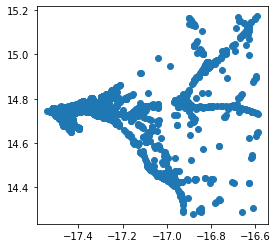

In [4]:
dakar.plot()

In [5]:
dkar = gpd.read_file("C:/Users/PC/Desktop/TO DO LIST/GEO_UNIVERSITY/GEOSPATIAL_COVID_ANALYSIS/shapefiles/Shapefiles/sen_admbnda_adm2_1m_gov_ocha_20190426.shp")

In [6]:
dkar.head(2)

,Shape_Leng,Shape_Area,ADM2_FR,ADM2_PCODE,ADM2_REF,ADM2ALT1FR,ADM2ALT2FR,ADM1_FR,ADM1_PCODE,ADM0_FR,ADM0_PCODE,date,validOn,validTo,geometry
0,5.352440,0.561518,Bakel,SN1201,None,None,None,Tambacounda,SN12,Senegal,SN,2017-08-04,2019-04-26,None,"POLYGON ((-12.66549 15.11117, -12.66378 15.111..."
1,1.453167,0.112038,Bambey,SN0201,None,None,None,Diourbel,SN02,Senegal,SN,2017-08-04,2019-04-26,None,"POLYGON ((-16.41398 15.02491, -16.40452 15.023..."


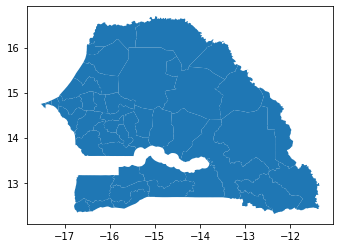

In [7]:
dkar.plot()

+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs


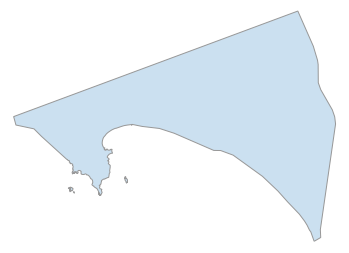

+proj=utm +zone=28 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


In [8]:
# Loading Dakar city from OpenStreetMap

dakar= ox.gdf_from_place("Dakar, Senegal", which_result=3)

#Let's print the crs coordinate system of Dakar
print(dakar.crs)

# Projecting the Dakar city
dakar =ox.project_gdf(dakar)

fig, ax = ox.plot_shape(dakar)

print(dakar.crs)

In [9]:
geometry = dakar["geometry"].iloc[0]
print(type(geometry))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


# A coordinate reference system (CRS)

### A coordinate reference system (CRS) is a coordinate-based local, regional or global system used to locate geographical entities. – Wikipedia

A coordinate reference system (CRS) is a coordinate-based local, regional or global system used to locate geographical entities. – Wikipedia

The Components of a CRS
The coordinate reference system is made up of several key components:

Coordinate system: The X, Y grid upon which your data is overlayed and how you define where a point is located in space.
Horizontal and vertical units: The units used to define the grid along the x, y (and z) axis.
Datum: A modeled version of the shape of the Earth which defines the origin used to place the coordinate system in space. You will learn this further below.
Projection Information: The mathematical equation used to flatten objects that are on a round surface (e.g. the Earth) so you can view them on a flat surface (e.g. your computer screens or a paper map).
Why CRS is Important
It is important to understand the coordinate system that your data uses - particularly if you are working with different data stored in different coordinate systems. If you have data from the same location that are stored in different coordinate reference systems, they will not line up in any GIS or other program unless you have a program like ArcGIS or QGIS that supports projection on the fly. Even if you work in a tool that supports projection on the fly, you will want to all of your data in the same projection for performing analysis and processing tasks.

 Data Tip: spatialreference.org provides an excellent online library of CRS information.

Coordinate System & Units
You can define a spatial location, such as a plot location, using an x- and a y-value - similar to your cartesian coordinate system displayed in the figure, above.

For example, the map below, generated in R with ggplot2 shows all of the continents in the world, in a Geographic Coordinate Reference System. The units are degrees and the coordinate system itself is latitude and longitude with the origin being the location where the equator meets the central meridian on the globe (0,0).



In [10]:
# Saving the city shapefile
dakar.to_file("C:/Users/PC/Desktop/TO DO LIST/GEO_UNIVERSITY/GEOSPATIAL_COVID_ANALYSIS/dakar.shp")

In [11]:
# # # Subdividing the city into grid of 1 km2 for modeling purposes. 

# First of all we will assign the geopetric polygon as a varibale

geometry = dakar['geometry'].iloc[0]

print(type(geometry))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


In [12]:
# Sudviding the city into a grid

geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=1750)
print(type(geometry_cut))

<class 'shapely.geometry.multipolygon.MultiPolygon'>


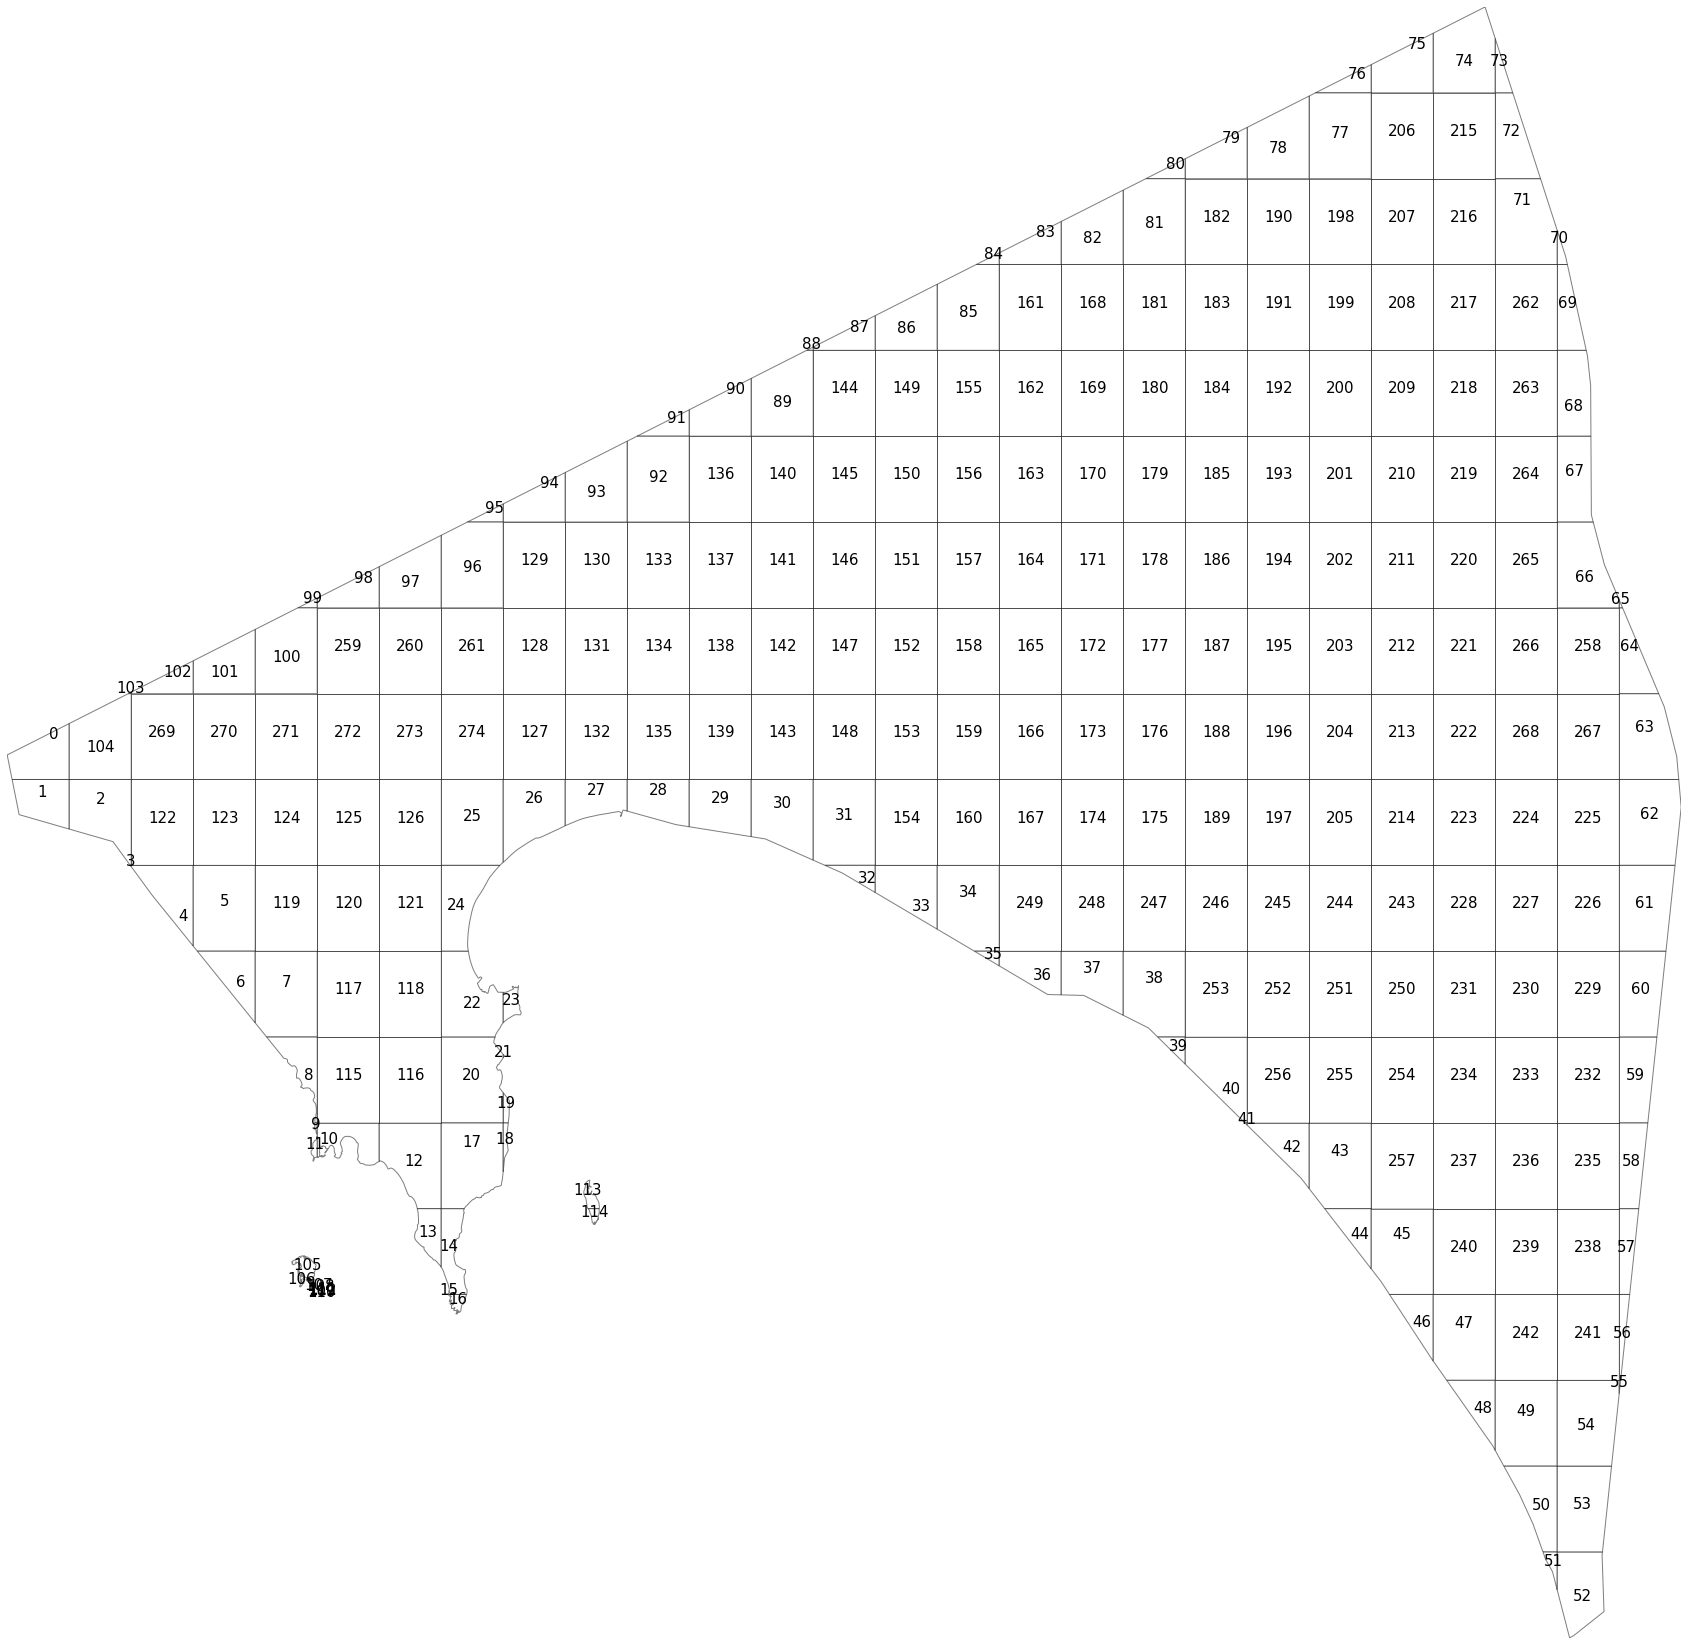

In [13]:
polylist = [p for p in geometry_cut]

# Plot city

west, south, east, north = dakar.unary_union.bounds

fig, ax = plt.subplots(figsize=(30,30))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p= polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p, horizontalalignment='center', size=15)
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [14]:
# Lets transform the polylist into a dataframe

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = dakar.crs
print(polyframe.crs)
polyframe.head()

,geometry
0,"POLYGON ((225697.749 1631440.888, 225562.340 1..."
1,"POLYGON ((227271.214 1630438.132, 225891.760 1..."
2,"POLYGON ((228954.682 1629704.785, 228477.841 1..."
3,"POLYGON ((228980.087 1629679.290, 228954.682 1..."
4,"POLYGON ((230688.961 1628071.817, 229554.330 1..."


In [15]:
# Number of polygons expected
len(polyframe)

+proj=utm +zone=28 +ellps=WGS84 +datum=WGS84 +units=m +no_defs


275

In [ ]:
import contextily as ctx
# Let's note ctx uses the crs epsg = 3857. In order to use it, it needs to be converted,

polyframe_3857 = polyframe.to_crs(epsg=3857)
west, south, east, north = polyframe_3857.unary_union.bounds # Here instead of using Dakar.unary_union_bounds we give polyframe_3857 = polyframe.to_crs(epsg=3857)

ax = polyframe_3857.plot(figsize=(40, 40), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, zoom=13)
ax.set_xlim(west,east)
ax.set_ylim(south, north)

C:\Users\PC\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
l= len(polylist)
# The Origin-Destination matrix
OD_matrix = np.zeros(shape=(l,l))
print(OD_matrix)

# To be continued